In [1]:
import timm
import open_clip
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
torch.set_grad_enabled(False)
import psutil
from lavis.models.eva_vit import create_eva_vit_g
from lavis.common.registry import registry
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm
import gc
import cv2
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
def print_mem_stats():
    mem = psutil.virtual_memory()
    total_system_memory = mem.total / (1024 ** 2)
    used_system_memory = mem.used / (1024 ** 2)
    total_gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024 ** 2)
    reserved_gpu_memory = torch.cuda.memory_reserved(0) / (1024 ** 2)
    allocated_gpu_memory = torch.cuda.memory_allocated(0) / (1024 ** 2)
    percent_gpu_total = (allocated_gpu_memory / total_gpu_memory)*100
    percent_gpu_reserved = (reserved_gpu_memory / total_gpu_memory)*100
    percent_cpu_total = (used_system_memory / total_system_memory)*100
    print(f"mem used gpu: {allocated_gpu_memory:.2f} MB, reserved gpu: {reserved_gpu_memory:.2f}MB -> {percent_gpu_total:.2f}% of total, {percent_gpu_reserved:.2f}% reserved")
    print(f"mem used cpu: {used_system_memory:.2f} MB -> {percent_cpu_total:.2f}% of total")

print_mem_stats()

mem used gpu: 0.00 MB, reserved gpu: 0.00MB -> 0.00% of total, 0.00% reserved
mem used cpu: 4589.64 MB -> 9.52% of total


In [3]:
pixelwise_features = torch.load("blip_noneva_pixelwise_rendfet_features_reduced.pt").unsqueeze(0).float()
xyz_pts = torch.load("blip_noneva_pixelwise_rendfet_xyz_reduced.pt").unsqueeze(0).float()

In [4]:
ckpt_path = "checkpoints/pretrain_blip2_sam_flant5xl_v2.pth"
model_cfg = {
    "arch": "blip2_t5",
    "model_type": "pretrain_flant5xl",
    "use_grad_checkpoint": False,
}
model_cfg = OmegaConf.create(model_cfg)
print_mem_stats()

mem used gpu: 0.00 MB, reserved gpu: 0.00MB -> 0.00% of total, 0.00% reserved
mem used cpu: 4723.08 MB -> 9.80% of total


In [5]:
model = registry.get_model_class("blip2_t5").from_pretrained(model_type="pretrain_flant5xl")
print_mem_stats()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

mem used gpu: 0.46 MB, reserved gpu: 2.00MB -> 0.00% of total, 0.01% reserved
mem used cpu: 20472.83 MB -> 42.48% of total


In [6]:
checkpoint = torch.load(ckpt_path, map_location="cpu")
print_mem_stats()

mem used gpu: 0.46 MB, reserved gpu: 2.00MB -> 0.00% of total, 0.01% reserved
mem used cpu: 24731.48 MB -> 51.32% of total


In [7]:
model.load_state_dict(checkpoint["model"], strict=False)
print_mem_stats()

mem used gpu: 0.46 MB, reserved gpu: 2.00MB -> 0.00% of total, 0.01% reserved
mem used cpu: 24733.27 MB -> 51.32% of total


In [8]:
model.eval()
model.to(cpu_device)
print_mem_stats()

mem used gpu: 0.46 MB, reserved gpu: 2.00MB -> 0.00% of total, 0.01% reserved
mem used cpu: 24734.04 MB -> 51.33% of total


In [9]:
processor_cfg = {"name": "blip_question", "prompt": ""}
processor_cfg = OmegaConf.create(processor_cfg)
text_processor = registry.get_processor_class(processor_cfg.name).from_config(processor_cfg)
print_mem_stats()

mem used gpu: 0.46 MB, reserved gpu: 2.00MB -> 0.00% of total, 0.01% reserved
mem used cpu: 24733.86 MB -> 51.33% of total


In [10]:
outfeat = pixelwise_features.to(cpu_device)
xyz_pts = xyz_pts.to(cpu_device)
prompt = text_processor("Describe the 3D scene in one sentence.")

model_inputs = {"text_input": prompt, "pc_feat": outfeat, "pc": xyz_pts}
model_outputs = model.predict_answers(
    samples=model_inputs,
    max_len=50,
    length_penalty=1.2,
    repetition_penalty=1.5,
)
model_outputs = model_outputs[0]
print(model_outputs)
print_mem_stats()

/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `1.2` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


<pad> the door that is farthest from the backpack</s>
mem used gpu: 0.46 MB, reserved gpu: 222.00MB -> 0.00% of total, 0.99% reserved
mem used cpu: 24845.05 MB -> 51.56% of total


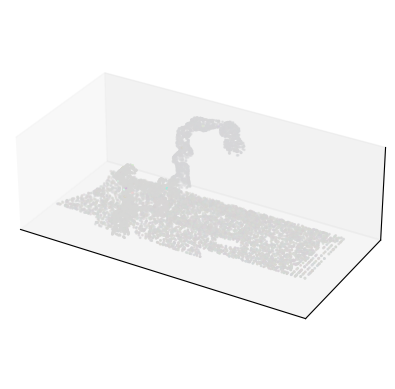

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure().add_subplot(111, projection="3d")
tsne = TSNE(n_components=3, random_state=0, learning_rate=200, init="random")
idx = np.random.choice(outfeat.shape[1], 10000)
pc_feature = outfeat[:, idx, :]
pc_points = xyz_pts[:, idx, :]
pc_feature = pc_feature.squeeze(0).cpu().numpy()  # (N, 1408)
pc_points = pc_points.squeeze(0).cpu().numpy()  # (N, 3)
pc_feature = tsne.fit_transform(pc_feature)  # (N, 3)
pc_feature = (pc_feature - pc_feature.min()) / (pc_feature.max() - pc_feature.min() + 1e-6) # normalize
ax.scatter(pc_points[:, 0], pc_points[:, 1], pc_points[:, 2], c=pc_feature, s=1)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

In [12]:
import torch
import numpy as np
alternative_feats = torch.load("/home/owenburns88/3D-LLM/3DLLM_BLIP2-base/assets/scene0480_00.pt")
alternative_pcs = torch.from_numpy(np.load("/home/owenburns88/3D-LLM/3DLLM_BLIP2-base/assets/scene0480_00.npy"))
pixelwise_features = torch.load("blip_noneva_pixelwise_rendfet_features_reduced.pt")
xyz_pts = torch.load("blip_noneva_pixelwise_rendfet_xyz_reduced.pt")

print(alternative_feats.shape)
print(alternative_pcs.shape)
print(pixelwise_features.shape)
print(xyz_pts.shape)

torch.Size([13991, 1408])
torch.Size([13991, 3])
torch.Size([18686, 1408])
torch.Size([18686, 3])


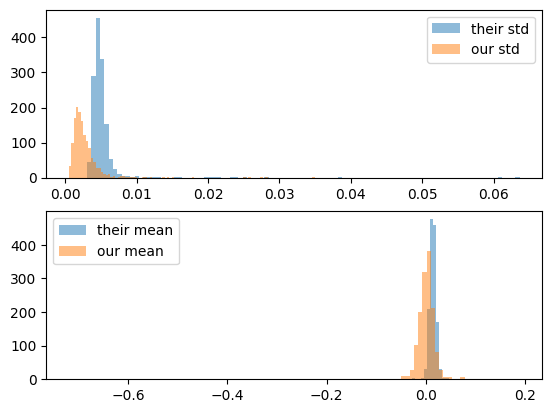

In [13]:
their_std = torch.std(alternative_feats, dim=0)
their_mean = torch.mean(alternative_feats, dim=0)
our_std = torch.std(pixelwise_features, dim=0)
our_mean = torch.mean(pixelwise_features, dim=0)

# plot a histogram
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2)
axs[0].hist(their_std.numpy(), bins=100, alpha=0.5, label="their std")
axs[0].hist(our_std.numpy(), bins=100, alpha=0.5, label="our std")
axs[0].legend()
axs[1].hist(their_mean.numpy(), bins=100, alpha=0.5, label="their mean")
axs[1].hist(our_mean.numpy(), bins=100, alpha=0.5, label="our mean")
axs[1].legend()
plt.show()